# Exploratory Data Analysis: OKE Challenge Evaluation Dataset

This notebook performs a comprehensive EDA on the `evaluation-dataset-task1.ttl` file, which contains NIF (NLP Interchange Format) annotations for named entity recognition from the OKE (Open Knowledge Extraction) challenge.

## 1. Import Required Libraries

In [75]:
import pandas as pd
import numpy as np

from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS, OWL

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Load TTL File

In [76]:
ttl_files = glob.glob('OKE/*.ttl')
print(f"Found TTL files: {ttl_files}")

if ttl_files:
    ttl_file = ttl_files[0]
    print(f"\nUsing file: {ttl_file}")
    file_size = os.path.getsize(ttl_file) / (1024 * 1024)
    print(f"File size: {file_size:.2f} MB")
else:
    raise FileNotFoundError("No TTL file found in the current directory")

Found TTL files: ['OKE\\evaluation-dataset-task1.ttl']

Using file: OKE\evaluation-dataset-task1.ttl
File size: 0.43 MB


## 3. Parse RDF Data

In [77]:
g = Graph()
print("Parsing TTL file...")
g.parse(ttl_file, format='turtle')
print(f"✓ Successfully parsed {len(g)} triples")

NIF = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
DUL = Namespace("http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#")
ITSRDF = Namespace("http://www.w3.org/2005/11/its/rdf#")
OKE = Namespace("http://www.ontologydesignpatterns.org/data/oke-challenge/task-1/sentence-")
DBPEDIA = Namespace("http://dbpedia.org/resource/")

Parsing TTL file...
✓ Successfully parsed 6864 triples
✓ Successfully parsed 6864 triples


## 4. Extract Data Structure

In [78]:
triples = []
for subj, pred, obj in g:
    triples.append({
        'subject': str(subj),
        'predicate': str(pred),
        'object': str(obj)
    })

df_triples = pd.DataFrame(triples)
print(f"Created DataFrame with {len(df_triples)} rows")
print(f"\nFirst few triples:")
df_triples.head(10)

Created DataFrame with 6864 rows

First few triples:


,subject,predicate,object
0,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/2005/11/its/rdf#taIdentRef,http://www.ontologydesignpatterns.org/data/oke...
1,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/2005/11/its/rdf#taIdentRef,http://www.ontologydesignpatterns.org/data/oke...
2,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/2005/11/its/rdf#taIdentRef,http://www.ontologydesignpatterns.org/data/oke...
3,http://www.ontologydesignpatterns.org/data/oke...,http://persistence.uni-leipzig.org/nlp2rdf/ont...,59
4,http://www.ontologydesignpatterns.org/data/oke...,http://persistence.uni-leipzig.org/nlp2rdf/ont...,57
5,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.ontologydesignpatterns.org/ont/dul/...
6,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Individual
7,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://persistence.uni-leipzig.org/nlp2rdf/ont...
8,http://www.ontologydesignpatterns.org/data/oke...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://persistence.uni-leipzig.org/nlp2rdf/ont...
9,http://www.ontologydesignpatterns.org/data/oke...,http://persistence.uni-leipzig.org/nlp2rdf/ont...,7


### Extract Sentences (Contexts)

In [79]:
sentences = []
for s in g.subjects(RDF.type, NIF.Context):
    text = g.value(s, NIF.isString)
    if text:
        sentences.append({
            'uri': str(s),
            'text': str(text),
            'length': len(str(text))
        })

df_sentences = pd.DataFrame(sentences)
print(f"Found {len(df_sentences)} sentences/contexts")
print(f"\nSample sentences:")
df_sentences.head()

Found 101 sentences/contexts

Sample sentences:


,uri,text,length
0,http://www.ontologydesignpatterns.org/data/oke...,Mario Capecchi was born in the city of Verona ...,223
1,http://www.ontologydesignpatterns.org/data/oke...,John started with high expectations and enthus...,132
2,http://www.ontologydesignpatterns.org/data/oke...,"Mandela served 27 years in prison, initially o...",119
3,http://www.ontologydesignpatterns.org/data/oke...,In 2001 he became a professor of physics at th...,169
4,http://www.ontologydesignpatterns.org/data/oke...,Gordimer studied for a year at the University ...,151


### Extract Entities

In [80]:
entities = []

for entity_type in [DUL.Person, DUL.Place, DUL.Organization]:
    type_name = str(entity_type).split('/')[-1].replace('.owl#', ':')
    
    for s in g.subjects(RDF.type, entity_type):
        label = g.value(s, RDFS.label)
        same_as = g.value(s, OWL.sameAs)
        
        entities.append({
            'uri': str(s),
            'type': type_name,
            'label': str(label) if label else None,
            'dbpedia': str(same_as) if same_as else None
        })

df_entities = pd.DataFrame(entities)
print(f"Found {len(df_entities)} entities")
print(f"\nEntity types distribution:")
print(df_entities['type'].value_counts())
print(f"\nSample entities:")
df_entities.head(10)

Found 373 entities

Entity types distribution:
type
DUL:Person          165
DUL:Organization    119
DUL:Place            89
Name: count, dtype: int64

Sample entities:


,uri,type,label,dbpedia
0,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,F. W. De Klerk,http://dbpedia.org/resource/F._W._de_Klerk
1,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,J. Hans D. Jensen,http://dbpedia.org/resource/J._Hans_D._Jensen
2,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Her_2,None
3,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,His_4,None
4,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Frank Aydelotte,http://dbpedia.org/resource/Frank_Aydelotte
5,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Joseph Edward Mayer,http://dbpedia.org/resource/Joseph_Edward_Mayer
6,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Scofield Thayer,http://dbpedia.org/resource/Scofield_Thayer
7,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Robert F. Kennedy,http://dbpedia.org/resource/Robert_F._Kennedy
8,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Pauli,http://dbpedia.org/resource/Wolfgang_Pauli
9,http://www.ontologydesignpatterns.org/data/oke...,DUL:Person,Walter Ramberg,None


### Extract Annotations (Mentions)

In [81]:
annotations = []

for s in g.subjects(RDF.type, NIF.RFC5147String):
    if (s, RDF.type, NIF.Context) in g:
        continue
    
    anchor = g.value(s, NIF.anchorOf)
    begin = g.value(s, NIF.beginIndex)
    end = g.value(s, NIF.endIndex)
    context = g.value(s, NIF.referenceContext)
    ta_ident = g.value(s, ITSRDF.taIdentRef)
    
    annotations.append({
        'uri': str(s),
        'anchor': str(anchor) if anchor else None,
        'begin': int(begin) if begin else None,
        'end': int(end) if end else None,
        'context': str(context) if context else None,
        'entity_ref': str(ta_ident) if ta_ident else None
    })

df_annotations = pd.DataFrame(annotations)
print(f"Found {len(df_annotations)} annotations (entity mentions)")
print(f"\nSample annotations:")
df_annotations.head(10)

Found 664 annotations (entity mentions)

Sample annotations:


,uri,anchor,begin,end,context,entity_ref
0,http://www.ontologydesignpatterns.org/data/oke...,President,143.0,152,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
1,http://www.ontologydesignpatterns.org/data/oke...,girl,4.0,8,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
2,http://www.ontologydesignpatterns.org/data/oke...,Trinity College,29.0,44,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
3,http://www.ontologydesignpatterns.org/data/oke...,École Supérieure de Physique et de Chimie Indu...,83.0,138,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
4,http://www.ontologydesignpatterns.org/data/oke...,Martti Ahtisaari,9.0,25,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
5,http://www.ontologydesignpatterns.org/data/oke...,he,61.0,63,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
6,http://www.ontologydesignpatterns.org/data/oke...,elementary school,16.0,33,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
7,http://www.ontologydesignpatterns.org/data/oke...,lecturer,50.0,58,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
8,http://www.ontologydesignpatterns.org/data/oke...,Polytechnic Institute of Turin,108.0,138,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...
9,http://www.ontologydesignpatterns.org/data/oke...,Assistant Professor,24.0,43,http://www.ontologydesignpatterns.org/data/oke...,http://www.ontologydesignpatterns.org/data/oke...


## 5. Basic Statistics

In [82]:
print("DATASET OVERVIEW")
print("="*60)
print(f"Total triples: {len(df_triples):,}")
print(f"Unique subjects: {df_triples['subject'].nunique():,}")
print(f"Unique predicates: {df_triples['predicate'].nunique():,}")
print(f"Unique objects: {df_triples['object'].nunique():,}")
print(f"\nTotal sentences: {len(df_sentences):,}")
print(f"Total entities: {len(df_entities):,}")
print(f"Total annotations: {len(df_annotations):,}")

DATASET OVERVIEW
Total triples: 6,864
Unique subjects: 1,193
Unique predicates: 9
Unique objects: 1,874

Total sentences: 101
Total entities: 373
Total annotations: 664


In [83]:
print("SENTENCE STATISTICS")
print("="*60)
print(df_sentences['length'].describe())
print(f"\nShortest sentence: {df_sentences['length'].min()} characters")
print(f"Longest sentence: {df_sentences['length'].max()} characters")
print(f"Average sentence length: {df_sentences['length'].mean():.1f} characters")

SENTENCE STATISTICS
count    101.000000
mean     183.950495
std       65.569105
min       51.000000
25%      132.000000
50%      186.000000
75%      225.000000
max      402.000000
Name: length, dtype: float64

Shortest sentence: 51 characters
Longest sentence: 402 characters
Average sentence length: 184.0 characters


In [84]:
print("ENTITY STATISTICS")
print("="*60)
entity_counts = df_entities['type'].value_counts()
print(entity_counts)
print(f"\nTotal unique entities: {len(df_entities)}")
print(f"\nEntities with DBpedia links: {df_entities['dbpedia'].notna().sum()}")
print(f"Entities with labels: {df_entities['label'].notna().sum()}")

ENTITY STATISTICS
type
DUL:Person          165
DUL:Organization    119
DUL:Place            89
Name: count, dtype: int64

Total unique entities: 373

Entities with DBpedia links: 276
Entities with labels: 373


In [85]:
print("ANNOTATION STATISTICS")
print("="*60)

df_annotations['mention_length'] = df_annotations['end'] - df_annotations['begin']

print(f"Total annotations: {len(df_annotations)}")
print(f"\nAnnotation mention length statistics:")
print(df_annotations['mention_length'].describe())
print(f"\nAnnotations per sentence: {len(df_annotations) / len(df_sentences):.2f}")

ANNOTATION STATISTICS
Total annotations: 664

Annotation mention length statistics:
count    614.000000
mean      11.039088
std        8.042005
min        2.000000
25%        5.000000
50%        9.000000
75%       16.000000
max       58.000000
Name: mention_length, dtype: float64

Annotations per sentence: 6.57


In [86]:
print("TOP 20 MOST FREQUENT PREDICATES")
print("="*60)
predicate_counts = df_triples['predicate'].value_counts().head(20)
for pred, count in predicate_counts.items():
    pred_short = pred.split('#')[-1] if '#' in pred else pred.split('/')[-1]
    print(f"{pred_short:40s}: {count:5d}")

TOP 20 MOST FREQUENT PREDICATES
type                                    :  2488
endIndex                                :   765
beginIndex                              :   765
taIdentRef                              :   665
anchorOf                                :   665
referenceContext                        :   664
label                                   :   431
sameAs                                  :   320
isString                                :   101


## 6. Visualize Data Distribution

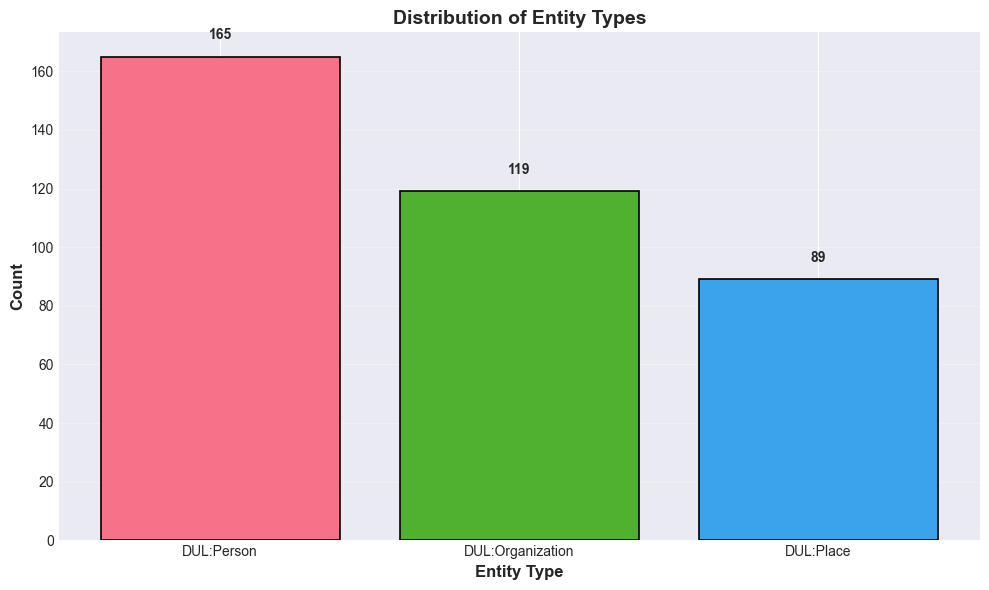

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
entity_counts = df_entities['type'].value_counts()
colors = sns.color_palette('husl', len(entity_counts))
ax.bar(entity_counts.index, entity_counts.values, color=colors, edgecolor='black', linewidth=1.2)
ax.set_xlabel('Entity Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Entity Types', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, (idx, val) in enumerate(entity_counts.items()):
    ax.text(i, val + 5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

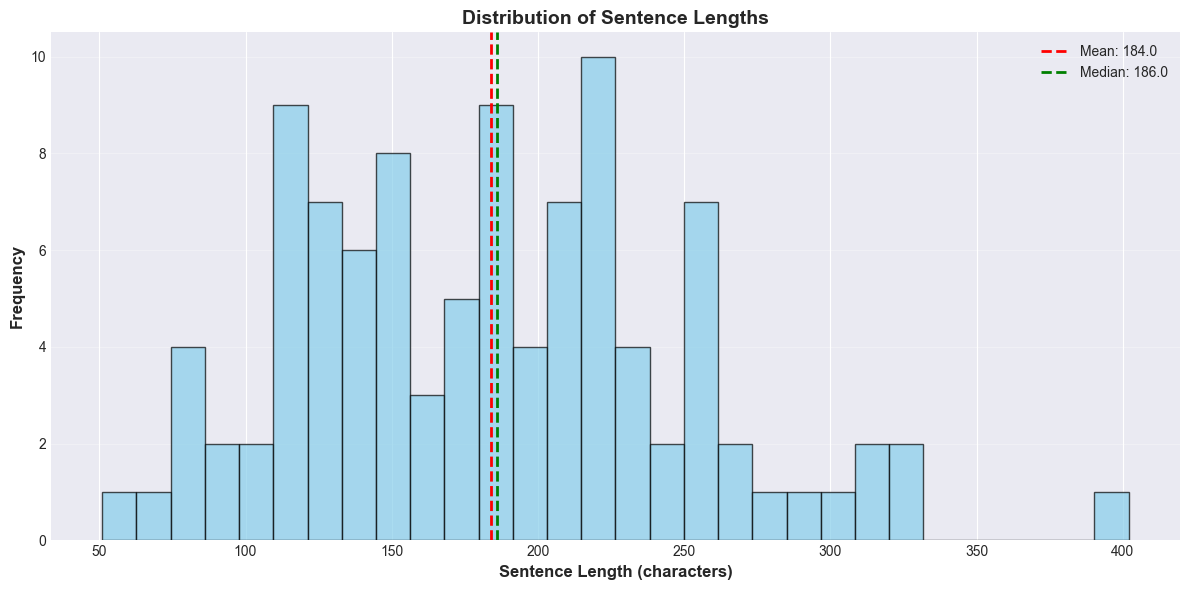

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df_sentences['length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(df_sentences['length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_sentences["length"].mean():.1f}')
ax.axvline(df_sentences['length'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_sentences["length"].median():.1f}')
ax.set_xlabel('Sentence Length (characters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Sentence Lengths', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

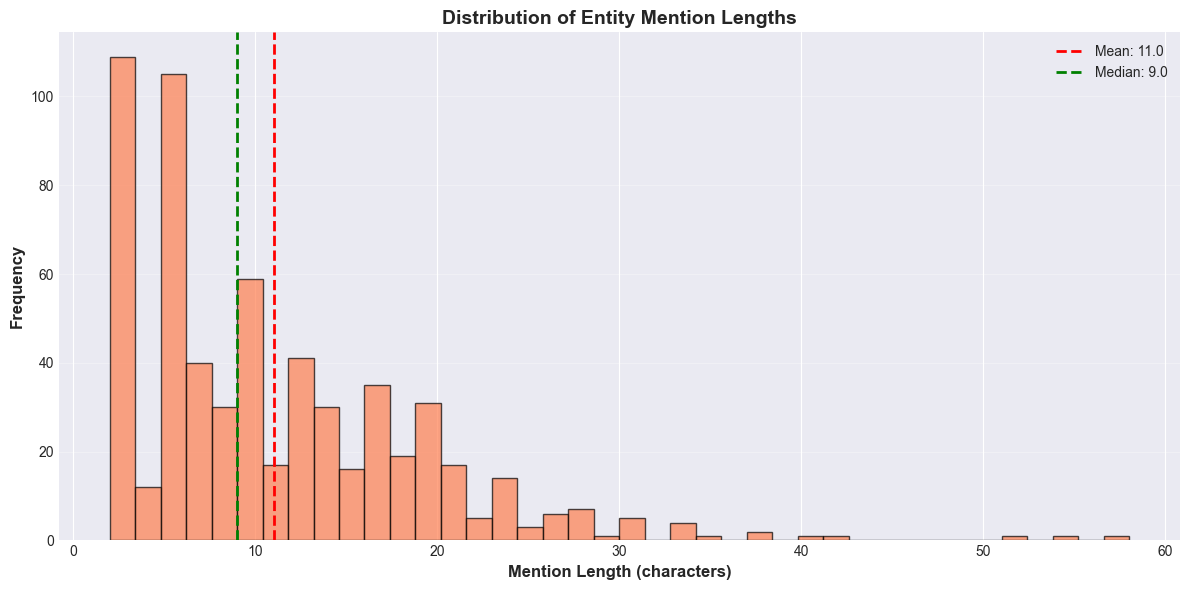

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df_annotations['mention_length'], bins=40, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(df_annotations['mention_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_annotations["mention_length"].mean():.1f}')
ax.axvline(df_annotations['mention_length'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_annotations["mention_length"].median():.1f}')
ax.set_xlabel('Mention Length (characters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Entity Mention Lengths', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

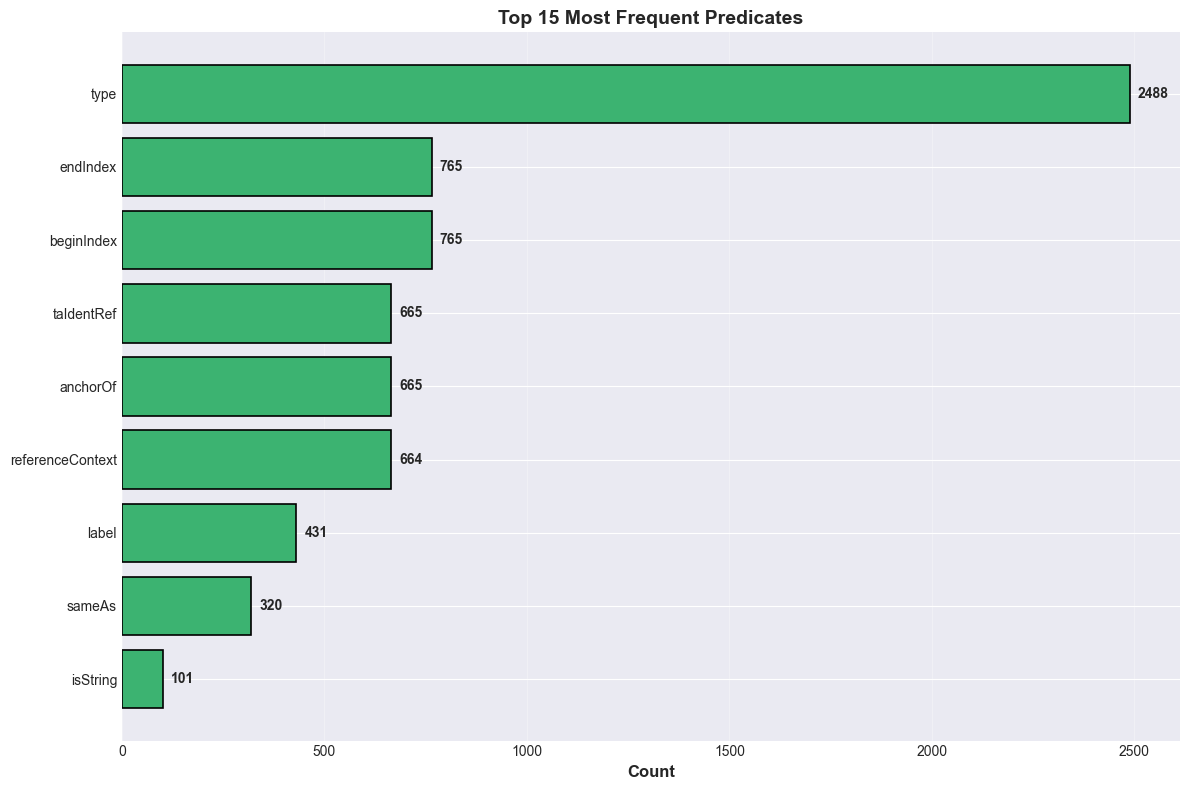

In [90]:
top_n = 15
pred_counts = df_triples['predicate'].value_counts().head(top_n)
pred_labels = [p.split('#')[-1] if '#' in p else p.split('/')[-1] for p in pred_counts.index]

fig, ax = plt.subplots(figsize=(12, 8))
y_pos = np.arange(len(pred_labels))
ax.barh(y_pos, pred_counts.values, color='mediumseagreen', edgecolor='black', linewidth=1.2)
ax.set_yticks(y_pos)
ax.set_yticklabels(pred_labels)
ax.invert_yaxis()
ax.set_xlabel('Count', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Frequent Predicates', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(pred_counts.values):
    ax.text(v + 20, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

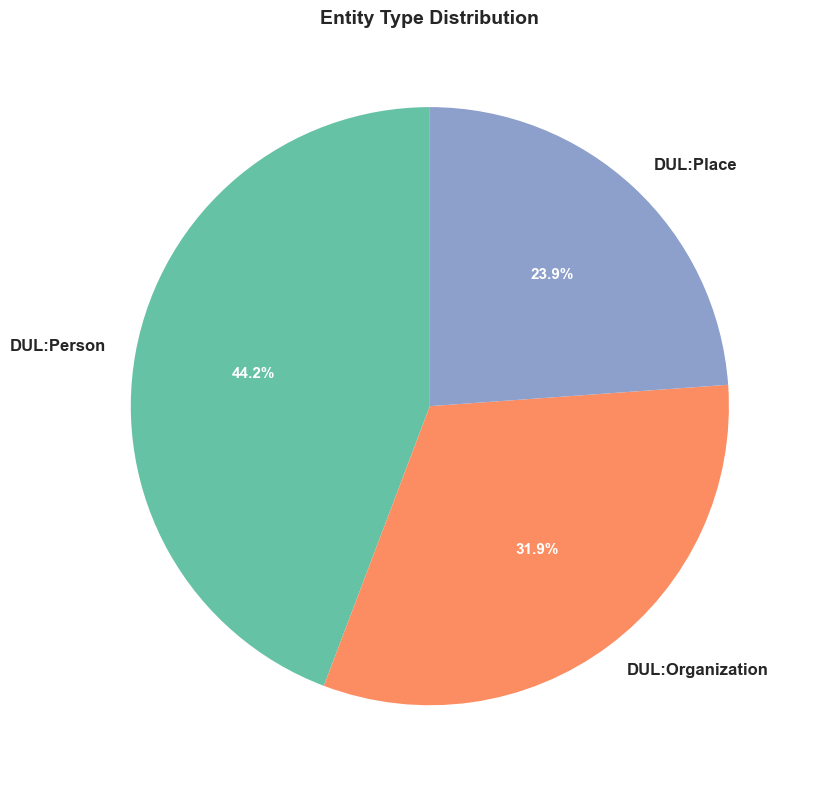

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette('Set2', len(entity_counts))
wedges, texts, autotexts = ax.pie(entity_counts.values, labels=entity_counts.index, autopct='%1.1f%%',
                                    colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Entity Type Distribution', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## 7. Analyze Relationships

Sentences with annotations: 101

Annotations per sentence statistics:
count    101.000000
mean       6.574257
std        2.765308
min        2.000000
25%        5.000000
50%        6.000000
75%        9.000000
max       16.000000
Name: count, dtype: float64


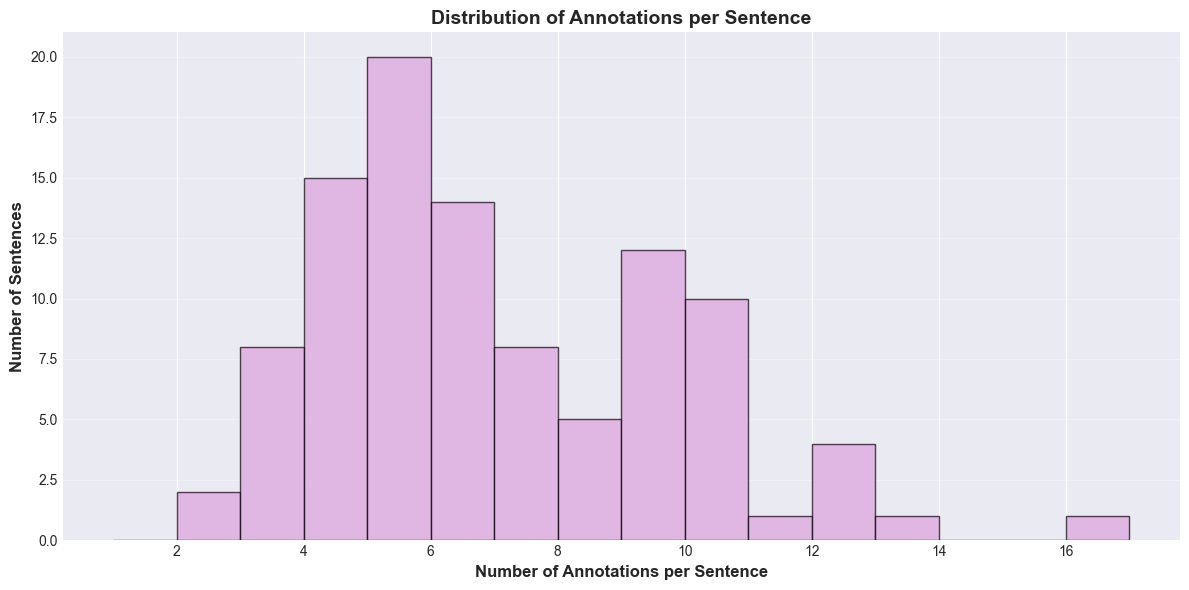

In [92]:
annotations_per_sentence = df_annotations.groupby('context').size().reset_index(name='count')
print(f"Sentences with annotations: {len(annotations_per_sentence)}")
print(f"\nAnnotations per sentence statistics:")
print(annotations_per_sentence['count'].describe())

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(annotations_per_sentence['count'], bins=range(1, annotations_per_sentence['count'].max()+2), 
        color='plum', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Annotations per Sentence', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Sentences', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Annotations per Sentence', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Top 20 most frequently mentioned entity texts:
anchor
his               31
he                31
her               10
He                 9
she                8
Paris              8
President          7
assistant          6
Wiesel             6
director           5
His                5
poet               5
man                5
United States      5
family             4
Eliot              4
Prelog             4
Goeppert Mayer     4
She                4
Neruda             4
Name: count, dtype: int64


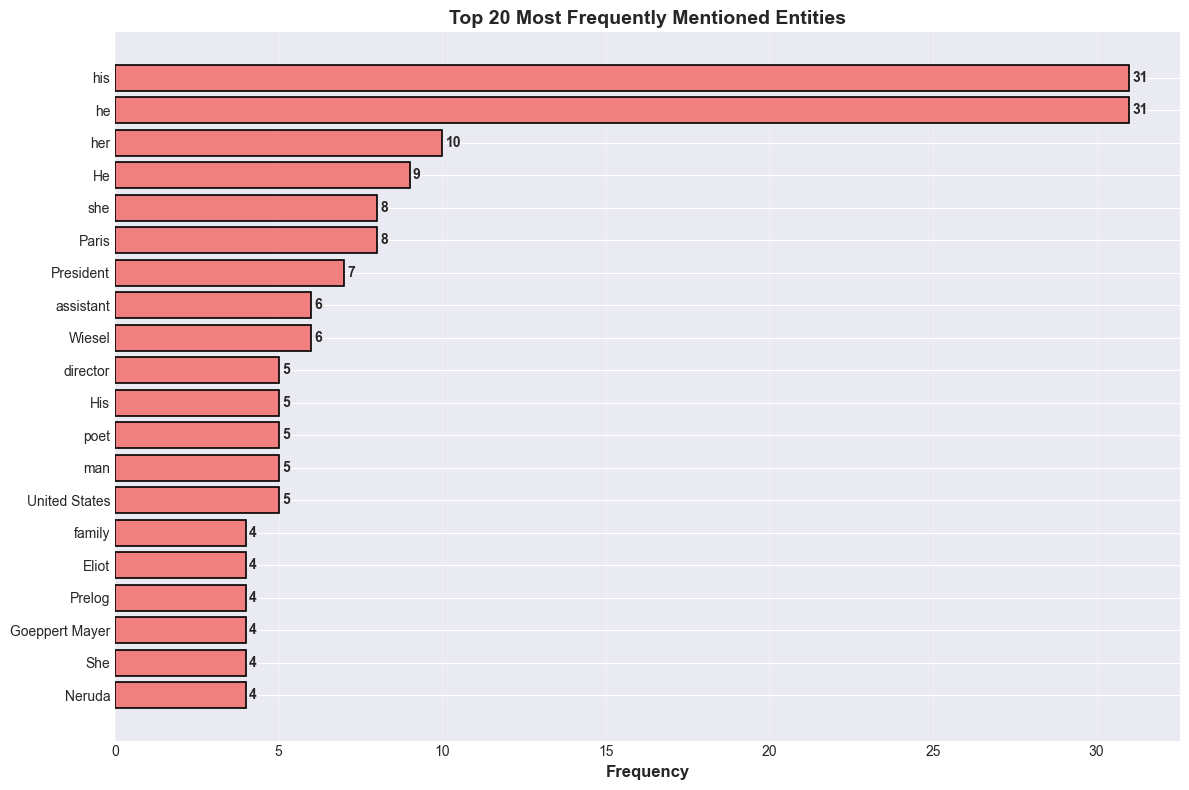

In [93]:
if 'anchor' in df_annotations.columns:
    top_mentions = df_annotations['anchor'].value_counts().head(20)
    print("Top 20 most frequently mentioned entity texts:")
    print(top_mentions)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(len(top_mentions))
    ax.barh(y_pos, top_mentions.values, color='lightcoral', edgecolor='black', linewidth=1.2)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_mentions.index)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Most Frequently Mentioned Entities', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(top_mentions.values):
        ax.text(v + 0.1, i, str(v), va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


Mentions by entity type:
type
DUL:Person          304
DUL:Organization    137
DUL:Place           120
Name: count, dtype: int64

type
DUL:Person          304
DUL:Organization    137
DUL:Place           120
Name: count, dtype: int64


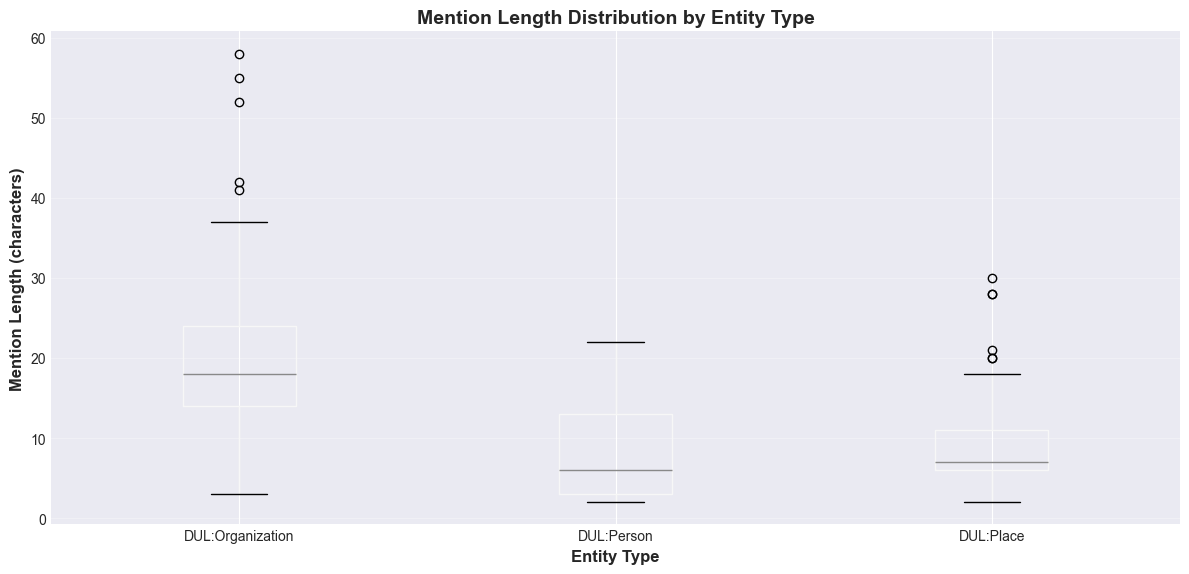

In [94]:
# Merge annotations with entities to analyze entity type mentions
# Extract entity URI from entity_ref
df_annotations['entity_uri_clean'] = df_annotations['entity_ref']

# Try to match with entities
entity_mentions_by_type = []

for _, annotation in df_annotations.iterrows():
    if pd.notna(annotation['entity_ref']):
        matching_entities = df_entities[df_entities['uri'] == annotation['entity_ref']]
        if not matching_entities.empty:
            entity_type = matching_entities.iloc[0]['type']
            entity_mentions_by_type.append({
                'anchor': annotation['anchor'],
                'type': entity_type,
                'mention_length': annotation['mention_length']
            })

if entity_mentions_by_type:
    df_mentions_typed = pd.DataFrame(entity_mentions_by_type)
    
    print("\nMentions by entity type:")
    print(df_mentions_typed['type'].value_counts())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    df_mentions_typed.boxplot(column='mention_length', by='type', ax=ax)
    ax.set_xlabel('Entity Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mention Length (characters)', fontsize=12, fontweight='bold')
    ax.set_title('Mention Length Distribution by Entity Type', fontsize=14, fontweight='bold')
    plt.suptitle('')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not match annotations with entity types for detailed analysis.")

## 8. Identify Missing Values and Data Quality

In [95]:
print("DATA QUALITY ANALYSIS")
print("="*60)

print("\nSentences DataFrame:")
print(f"  Missing text: {df_sentences['text'].isna().sum()}")
print(f"  Empty text: {(df_sentences['text'] == '').sum()}")

print("\nEntities DataFrame:")
print(f"  Missing labels: {df_entities['label'].isna().sum()}")
print(f"  Missing DBpedia links: {df_entities['dbpedia'].isna().sum()}")
print(f"  Entities with both label and DBpedia: {((df_entities['label'].notna()) & (df_entities['dbpedia'].notna())).sum()}")

print("\nAnnotations DataFrame:")
print(f"  Missing anchor text: {df_annotations['anchor'].isna().sum()}")
print(f"  Missing begin index: {df_annotations['begin'].isna().sum()}")
print(f"  Missing end index: {df_annotations['end'].isna().sum()}")
print(f"  Missing context reference: {df_annotations['context'].isna().sum()}")
print(f"  Missing entity reference: {df_annotations['entity_ref'].isna().sum()}")

DATA QUALITY ANALYSIS

Sentences DataFrame:
  Missing text: 0
  Empty text: 0

Entities DataFrame:
  Missing labels: 0
  Missing DBpedia links: 97
  Entities with both label and DBpedia: 276

Annotations DataFrame:
  Missing anchor text: 0
  Missing begin index: 50
  Missing end index: 0
  Missing context reference: 0
  Missing entity reference: 0


## 9. Sample Data Exploration

In [96]:
print("SAMPLE SENTENCES WITH ANNOTATIONS")
print("="*80)

sample_sentences = df_sentences.sample(min(5, len(df_sentences)))

for idx, row in sample_sentences.iterrows():
    print(f"\n[Sentence {idx+1}]")
    print(f"Text: {row['text'][:200]}..." if len(row['text']) > 200 else f"Text: {row['text']}")
    print(f"Length: {row['length']} characters")
    
    sentence_annotations = df_annotations[df_annotations['context'] == row['uri']]
    print(f"Annotations: {len(sentence_annotations)}")
    
    if not sentence_annotations.empty:
        for _, ann in sentence_annotations.head(5).iterrows():
            print(f"  - '{ann['anchor']}' at position {ann['begin']}-{ann['end']}")
    print("-" * 80)

SAMPLE SENTENCES WITH ANNOTATIONS

[Sentence 60]
Text: He was a boy scout, with the Boy Scouts of America and became an Eagle Scout. He attended Washington University in St. Louis for undergraduate studies as an Alexander S. Langsdorf Fellow, and obtained...
Length: 215 characters
Annotations: 9
  - 'boy scout' at position 9.0-18
  - 'Eagle Scout' at position 65.0-76
  - 'Washington University' at position 90.0-111
  - 'Boy Scouts of America' at position 29.0-50
  - 'Fellow' at position 180.0-186
--------------------------------------------------------------------------------

[Sentence 25]
Text: In 1946 a woman from Ghana working at RCA sent a friend money to return to the United States.
Length: 93 characters
Annotations: 5
  - 'Ghana' at position 21.0-26
  - 'RCA' at position 38.0-41
  - 'friend' at position 49.0-55
  - 'United States' at position 79.0-92
  - 'woman' at position 10.0-15
--------------------------------------------------------------------------------

[Sentence 31]
Te

In [97]:
print("SAMPLE ENTITIES BY TYPE")
print("="*80)

for entity_type in df_entities['type'].unique():
    print(f"\n{entity_type}:")
    sample_entities = df_entities[df_entities['type'] == entity_type].head(10)
    for _, entity in sample_entities.iterrows():
        label = entity['label'] if pd.notna(entity['label']) else "N/A"
        print(f"  - {label}")
    print("-" * 80)

SAMPLE ENTITIES BY TYPE

DUL:Person:
  - F. W. De Klerk
  - J. Hans D. Jensen
  - Her_2
  - His_4
  - Frank Aydelotte
  - Joseph Edward Mayer
  - Scofield Thayer
  - Robert F. Kennedy
  - Pauli
  - Walter Ramberg
--------------------------------------------------------------------------------

DUL:Place:
  - Kansas City metropolitan area
  - Jena
  - Canada
  - France
  - Ghettos
  - Pisa
  - Argentina
  - Verona
  - Belfast
  - Naples
--------------------------------------------------------------------------------

DUL:Organization:
  - Harvard Medical School
  - Cowles Foundation
  - Cavendish Laboratory
  - Umkhonto we Sizwe
  - Manchester Centre for Mesoscience and Nanotechnology
  - University of Western Ontario
  - Yale University
  - African National Congress
  - Carl Zeiss AG
  - Princeton University
--------------------------------------------------------------------------------


## 10. Summary and Key Findings

In [98]:
summary = f"""
EXPLORATORY DATA ANALYSIS SUMMARY

Dataset: {ttl_file}
File Size: {file_size:.2f} MB

1. OVERALL STRUCTURE
   - Total RDF Triples: {len(df_triples):,}
   - Unique Subjects: {df_triples['subject'].nunique():,}
   - Unique Predicates: {df_triples['predicate'].nunique():,}
   - Unique Objects: {df_triples['object'].nunique():,}

2. SENTENCES (CONTEXTS)
   - Total Sentences: {len(df_sentences):,}
   - Average Length: {df_sentences['length'].mean():.1f} characters
   - Shortest: {df_sentences['length'].min()} chars
   - Longest: {df_sentences['length'].max()} chars

3. ENTITIES
   - Total Unique Entities: {len(df_entities):,}
   - Persons: {(df_entities['type'] == 'DUL:Person').sum():,}
   - Places: {(df_entities['type'] == 'DUL:Place').sum():,}
   - Organizations: {(df_entities['type'] == 'DUL:Organization').sum():,}
   - With DBpedia Links: {df_entities['dbpedia'].notna().sum():,} ({df_entities['dbpedia'].notna().sum()/len(df_entities)*100:.1f}%)

4. ANNOTATIONS (ENTITY MENTIONS)
   - Total Annotations: {len(df_annotations):,}
   - Average per Sentence: {len(df_annotations) / len(df_sentences):.2f}
   - Average Mention Length: {df_annotations['mention_length'].mean():.1f} characters
   - Shortest Mention: {df_annotations['mention_length'].min()} chars
   - Longest Mention: {df_annotations['mention_length'].max()} chars

5. DATA QUALITY
   - Complete Annotations: {((df_annotations['anchor'].notna()) & (df_annotations['entity_ref'].notna())).sum():,}
   - Missing Entity Labels: {df_entities['label'].isna().sum():,}
   - Missing DBpedia Links: {df_entities['dbpedia'].isna().sum():,}
"""

print(summary)


EXPLORATORY DATA ANALYSIS SUMMARY

Dataset: OKE\evaluation-dataset-task1.ttl
File Size: 0.43 MB

1. OVERALL STRUCTURE
   - Total RDF Triples: 6,864
   - Unique Subjects: 1,193
   - Unique Predicates: 9
   - Unique Objects: 1,874

2. SENTENCES (CONTEXTS)
   - Total Sentences: 101
   - Average Length: 184.0 characters
   - Shortest: 51 chars
   - Longest: 402 chars

3. ENTITIES
   - Total Unique Entities: 373
   - Persons: 165
   - Places: 89
   - Organizations: 119
   - With DBpedia Links: 276 (74.0%)

4. ANNOTATIONS (ENTITY MENTIONS)
   - Total Annotations: 664
   - Average per Sentence: 6.57
   - Average Mention Length: 11.0 characters
   - Shortest Mention: 2.0 chars
   - Longest Mention: 58.0 chars

5. DATA QUALITY
   - Complete Annotations: 664
   - Missing Entity Labels: 0
   - Missing DBpedia Links: 97

